In [13]:
#######
# Starter code for Time Series Analysis and Forecasting
#
# You will need to install the YahooFinance Python api
#
# Using Anaconda environment:
# - conda install -c conda-forge yfinance
#
# Using pip 
# - pip install yfinance
#
# Veryify it is installed by importing it in your Jupyter Notebook.
# If you cannot get it to install, you can always Google Search
# "install yfinance Python library"  and it will give you search results
# that walk you through.   As of 13-Nov-2024 both methods work.
#
# https://stackoverflow.com/questions/39636128/yahoo-finance-package-installation-in-anaconda
###

In [3]:
#pip install pmdarima

In [4]:
#pip install sktime

In [5]:
#pip install statsmodels

In [6]:
import datetime 
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import numpy.linalg

import yfinance as yf
import pandas as pd

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler

from sktime.split import temporal_train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima 



In [10]:
#####
# 12-month data from 11/12/2023 to 11/12/2024
##
FY_START='2019-12-4'
FY_END='2024-12-4'

appleTicker='AAPL'
nvidiaTicker='NVDA'

In [11]:
NUM_BINS= 20

In [12]:
nvidiaData= yf.download(nvidiaTicker, start=FY_START,end= FY_END)
aaplData= yf.download(appleTicker, start=FY_START,end=FY_END)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [43]:
nvidiaData.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2019-12-04 00:00:00+00:00,5.214003,5.23550,5.29800,5.20675,5.27550,273424000
2019-12-05 00:00:00+00:00,5.197073,5.21850,5.27325,5.18775,5.25750,184884000
2019-12-06 00:00:00+00:00,5.282470,5.30425,5.33725,5.27800,5.28800,232236000
2019-12-09 00:00:00+00:00,5.282470,5.30425,5.35925,5.27250,5.28125,211880000
2019-12-10 00:00:00+00:00,5.327534,5.34950,5.40150,5.28150,5.33450,256388000


In [44]:
aaplData.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2019-12-04 00:00:00+00:00,63.438084,65.434998,65.827499,65.169998,65.267502,67181600
2019-12-05 00:00:00+00:00,64.368790,66.394997,66.472504,65.682503,65.947502,74424400
2019-12-06 00:00:00+00:00,65.612144,67.677498,67.750000,66.824997,66.870003,106075600
2019-12-09 00:00:00+00:00,64.693573,66.730003,67.699997,66.227501,67.500000,128042400
2019-12-10 00:00:00+00:00,65.071655,67.120003,67.517502,66.464996,67.150002,90420400


In [45]:
######
# To learn more, see multi-level columns in Pandas.
# They are kinda cool and make sense for complex aggregated data.
#
# https://pandas.pydata.org/docs/user_guide/advanced.html
#
# https://stackoverflow.com/questions/63107594/how-to-deal-with-multi-level-column-names-downloaded-with-yfinance
###
df_aapl_close = aaplData['Close'].AAPL

In [46]:
df_nvidia_close= nvidiaData['Close'].NVDA

In [47]:
df_aapl_close.describe()

count    1258.000000
mean      151.380117
std        41.047475
min        56.092499
25%       127.182499
50%       151.095001
75%       177.412498
max       242.649994
Name: AAPL, dtype: float64

In [48]:
df_nvidia_close.describe()

count    1258.000000
mean       36.487949
std        36.424667
min         4.910000
25%        13.430375
50%        20.646000
75%        44.587749
max       148.880005
Name: NVDA, dtype: float64

<Axes: >

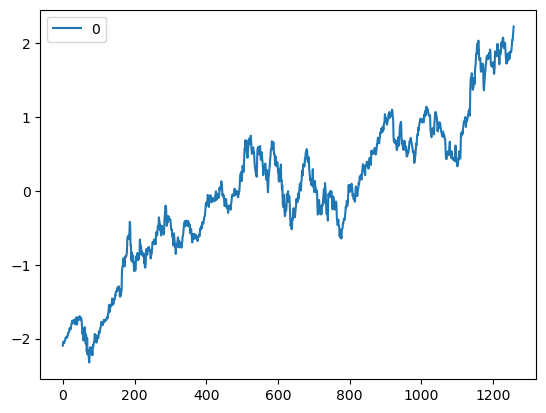

In [49]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_aapl_close.values.reshape(-1, 1)) 
scaled_series= pd.DataFrame(scaled_data)
scaled_series.plot()

In [53]:
#####
#  Visualizations of various transformations
###

def visTransformations(df_data, dataName, windowSize):
    plt.figure(1,figsize=(30,90))
    plt.subplot(10,1,1)
    df_data.plot()
    plt.title(f'{dataName} closing price')
    
    plt.subplot(10,1,2)
    plt.title(f'{dataName} filtered outliers')
    z_scores = zscore(df_data)
    abs_z_scores = np.abs(z_scores)
    filtered_data = (abs_z_scores < 2)  # Z-score trheshold two standard deviations
    series_no_outliers = df_data[filtered_data]
    series_no_outliers.plot()

#    plt.subplot(9,1,3)
#    plt.title('{dataName} scaled and filtered')
#    scaler = StandardScaler()
#    scaled_data = scaler.fit_transform(series_no_outliers.values.reshape(-1, 1)) 
#    scaled_series= pd.DataFrame(scaled_data)
#    scaled_series.plot()

    plt.subplot(10,1,3)
    binCountsAAPL, binEdgesAAPL, patchesAAPL= plt.hist(df_data,NUM_BINS)
    plt.title(f'{dataName} stock distribution')
    
    plt.subplot(10,1,4)
    plt.title(f'{dataName} rolling average win=%i' %windowSize )
    df_aapl_close.rolling(windowSize).mean().plot()
    
    plt.subplot(10,1,5)
    plt.title(f'{dataName} rolling std win=%i'%windowSize)
    df_data.rolling(windowSize).std().plot()
    
    plt.subplot(10,1,6)
    plt.title(f'{dataName} difference 1x')
    df_data.diff().plot()

    DIFF_ORDER= 10
    plt.subplot(10,1,7)
    plt.title(f'{dataName} difference {DIFF_ORDER}x')
    df_diff= df_data
    for i in range(DIFF_ORDER):
        df_diff= df_diff.diff()
        
    df_diff.plot()

    plt.subplot(10,1,8)
    plt.title(f'{dataName} mean diff win=%i' %windowSize)
    df_data.diff().rolling(windowSize).mean().plot()
    
    plt.subplot(10,1,9)
    plt.title(f'{dataName} std diff win=%i' %windowSize)
    df_data.diff().rolling(windowSize).std().plot()


    plt.subplot(10,1,10)
    plt.title(f'{dataName} scaled and filtered')
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(series_no_outliers.values.reshape(-1, 1)) 
    plt.plot(scaled_data)

In [57]:
##############
# Augmented Dickey-Fuller Test
#
# Ho: It is non-stationary
# H1: It is stationary
#
#####

def adfuller_test(sales):
    result=adfuller(sales)
    print(result)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

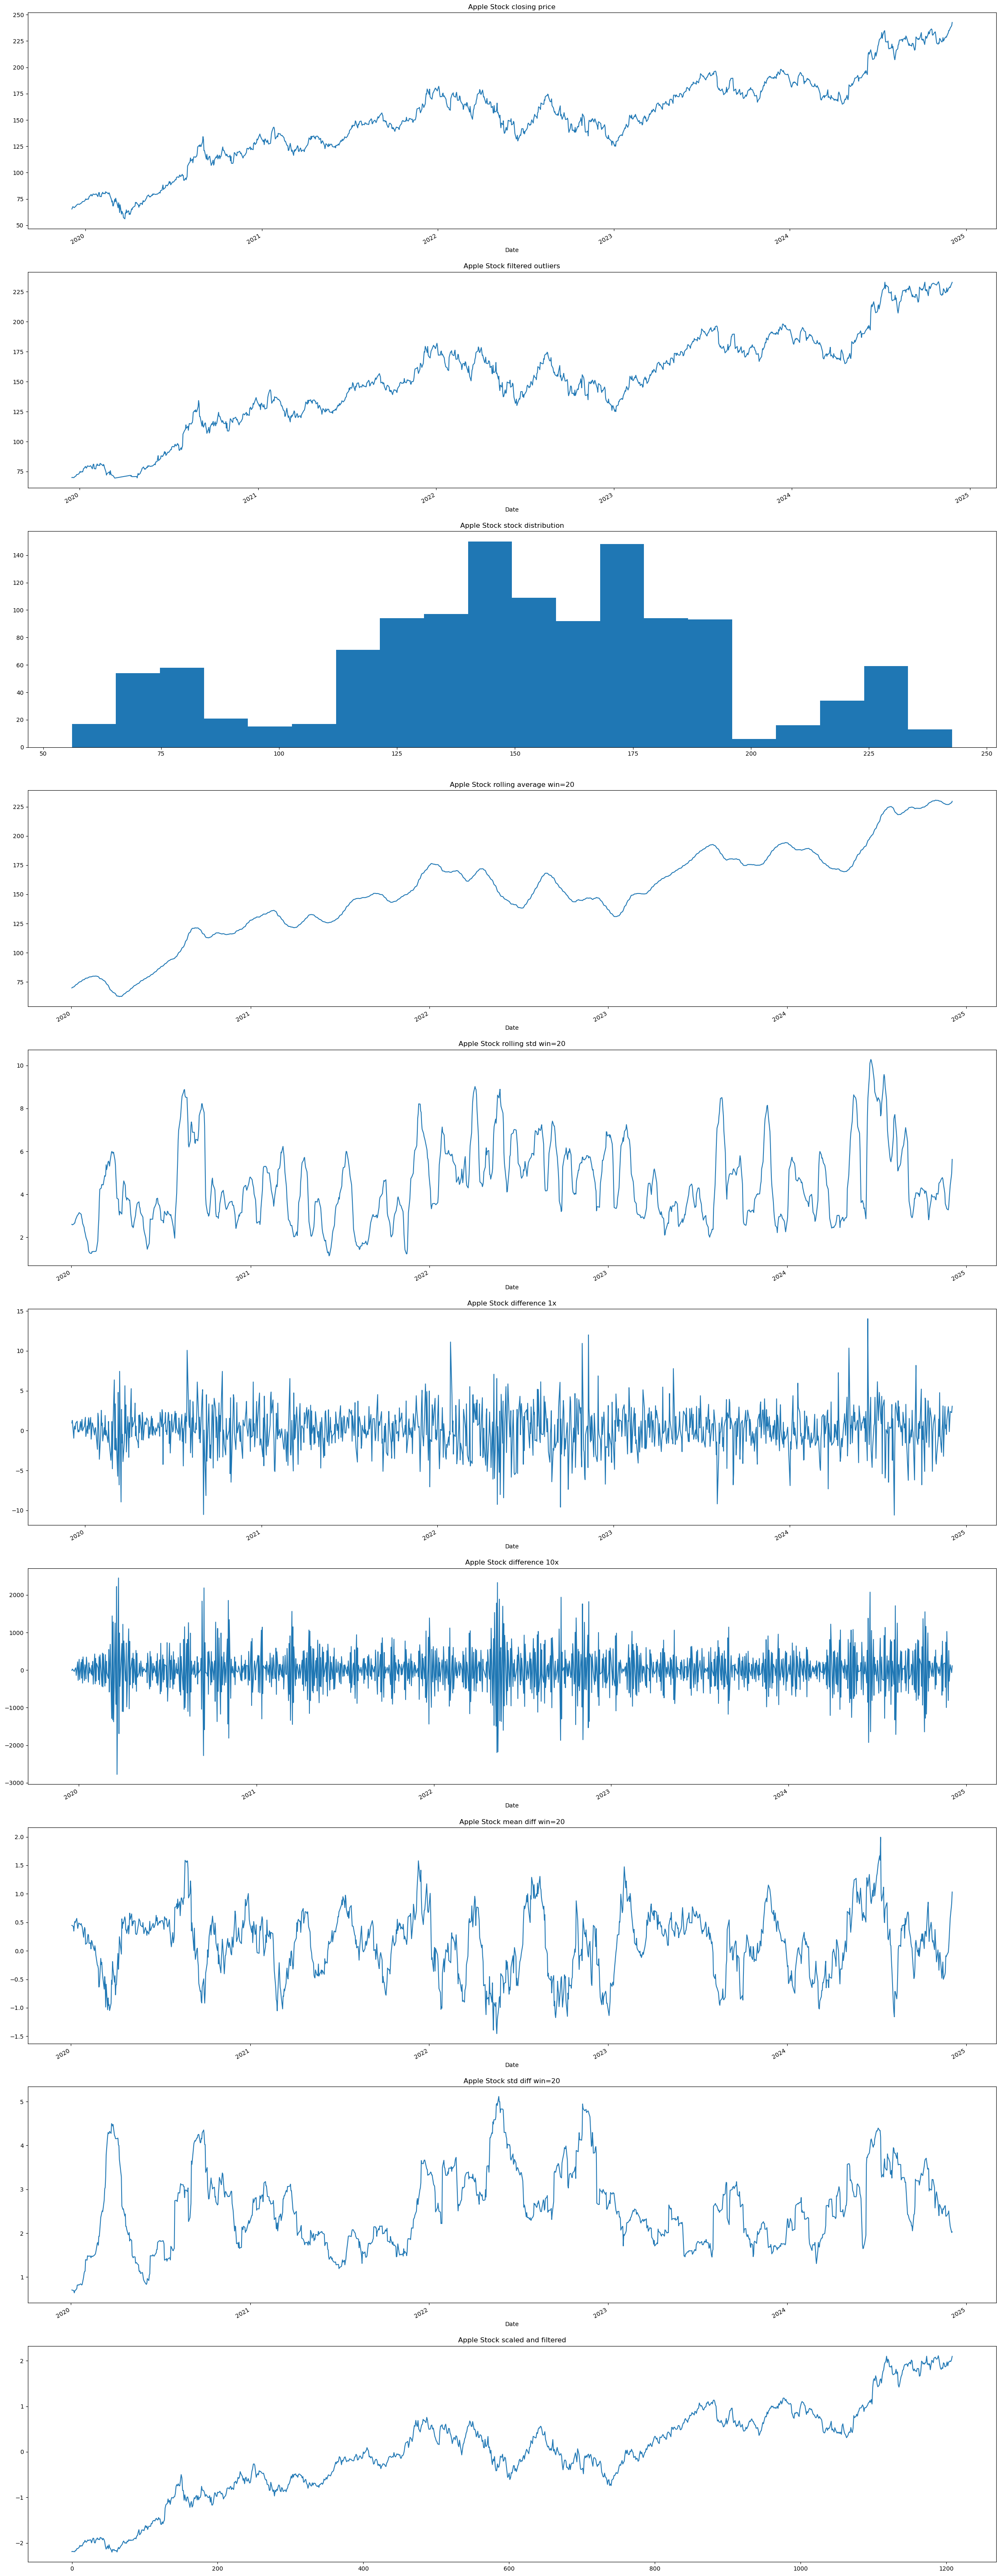

In [58]:
visTransformations(df_aapl_close,'Apple Stock',20)

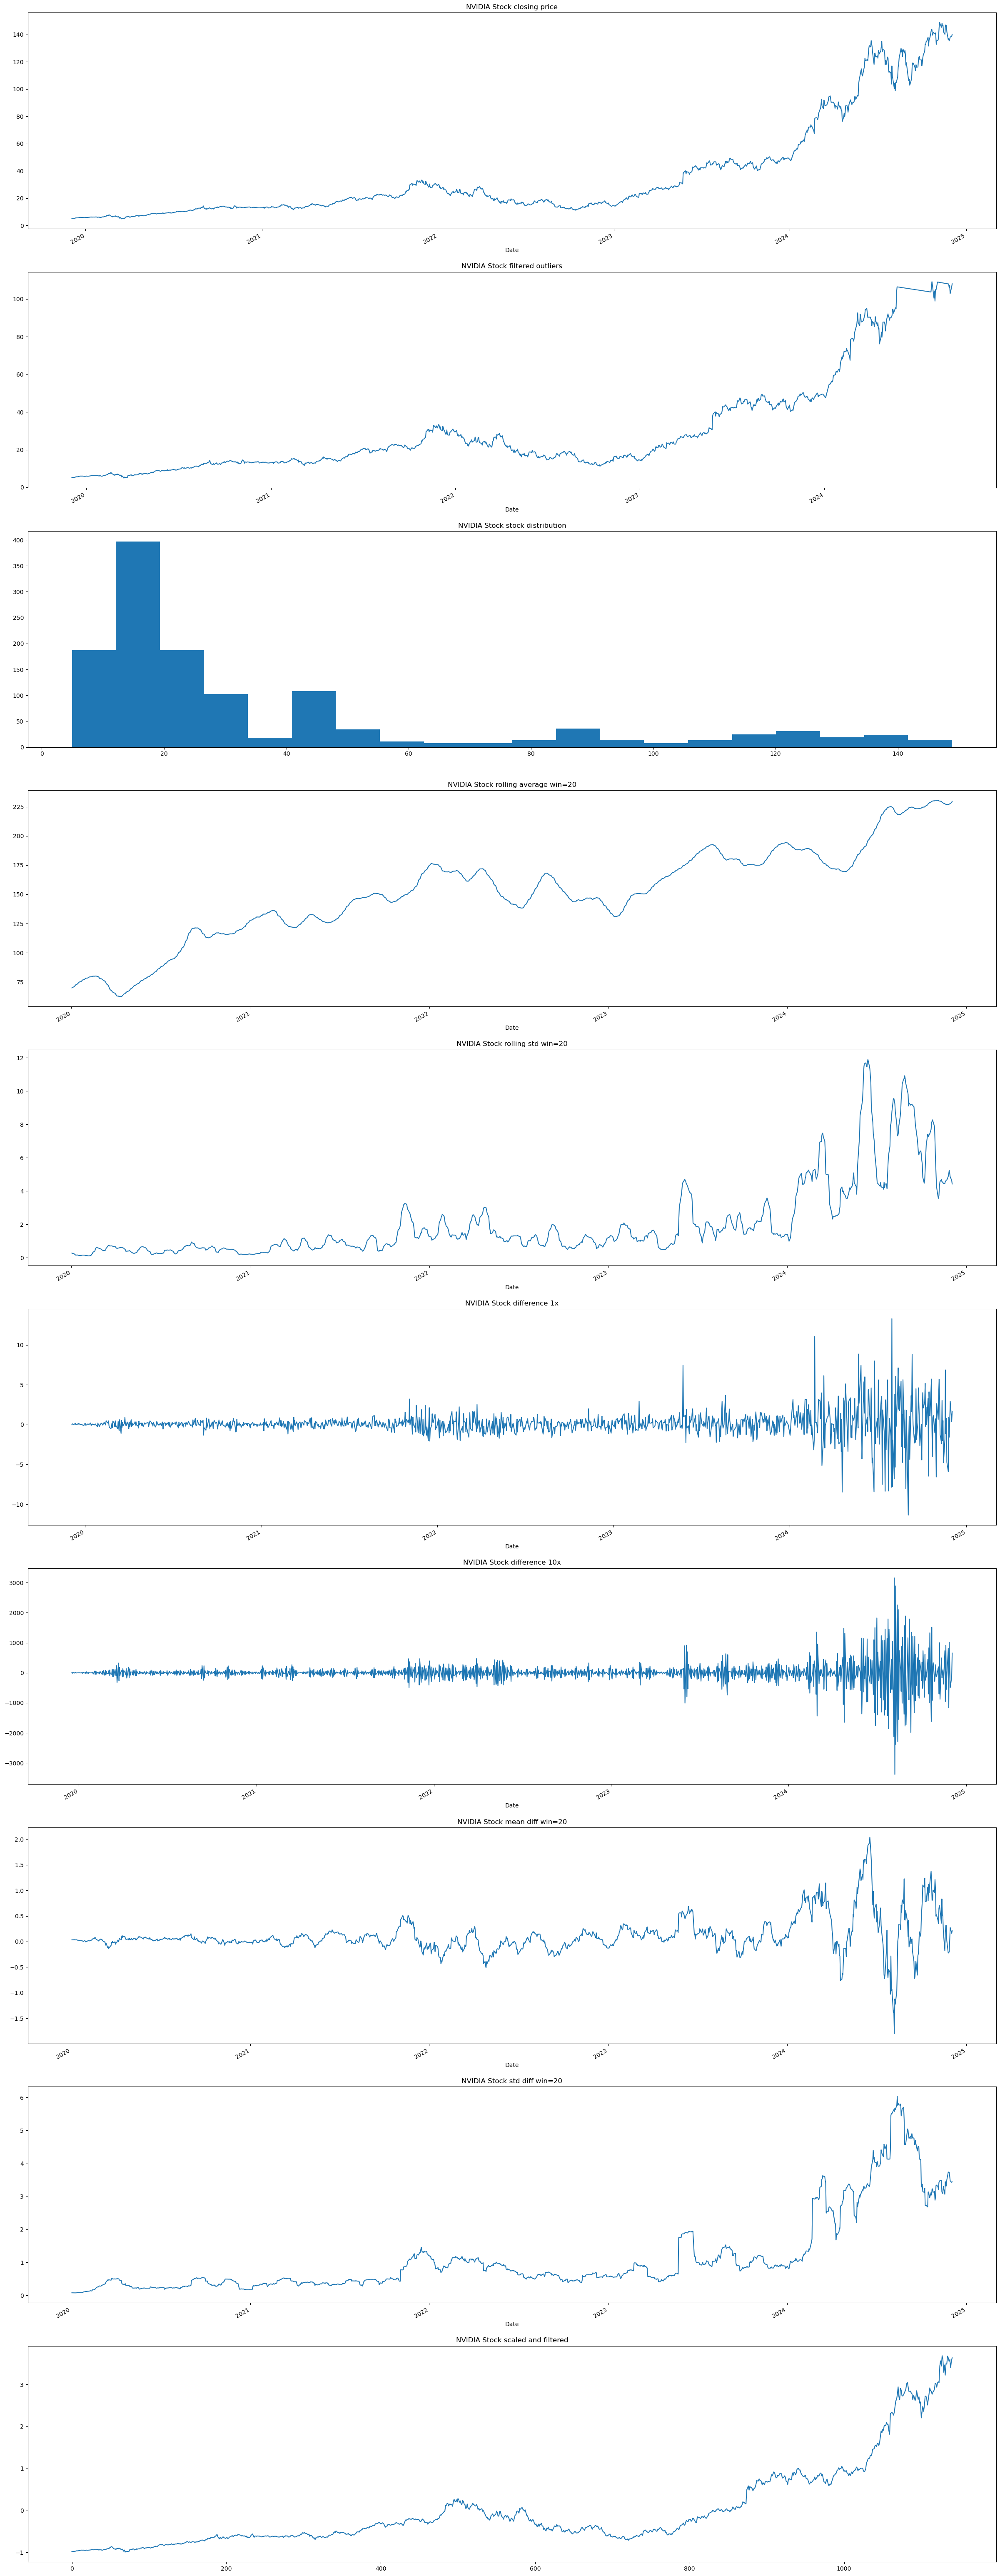

In [59]:
visTransformations(df_nvidia_close,'NVIDIA Stock',20)

In [60]:
df_aapl_close.size

1258

<Figure size 3000x1000 with 0 Axes>

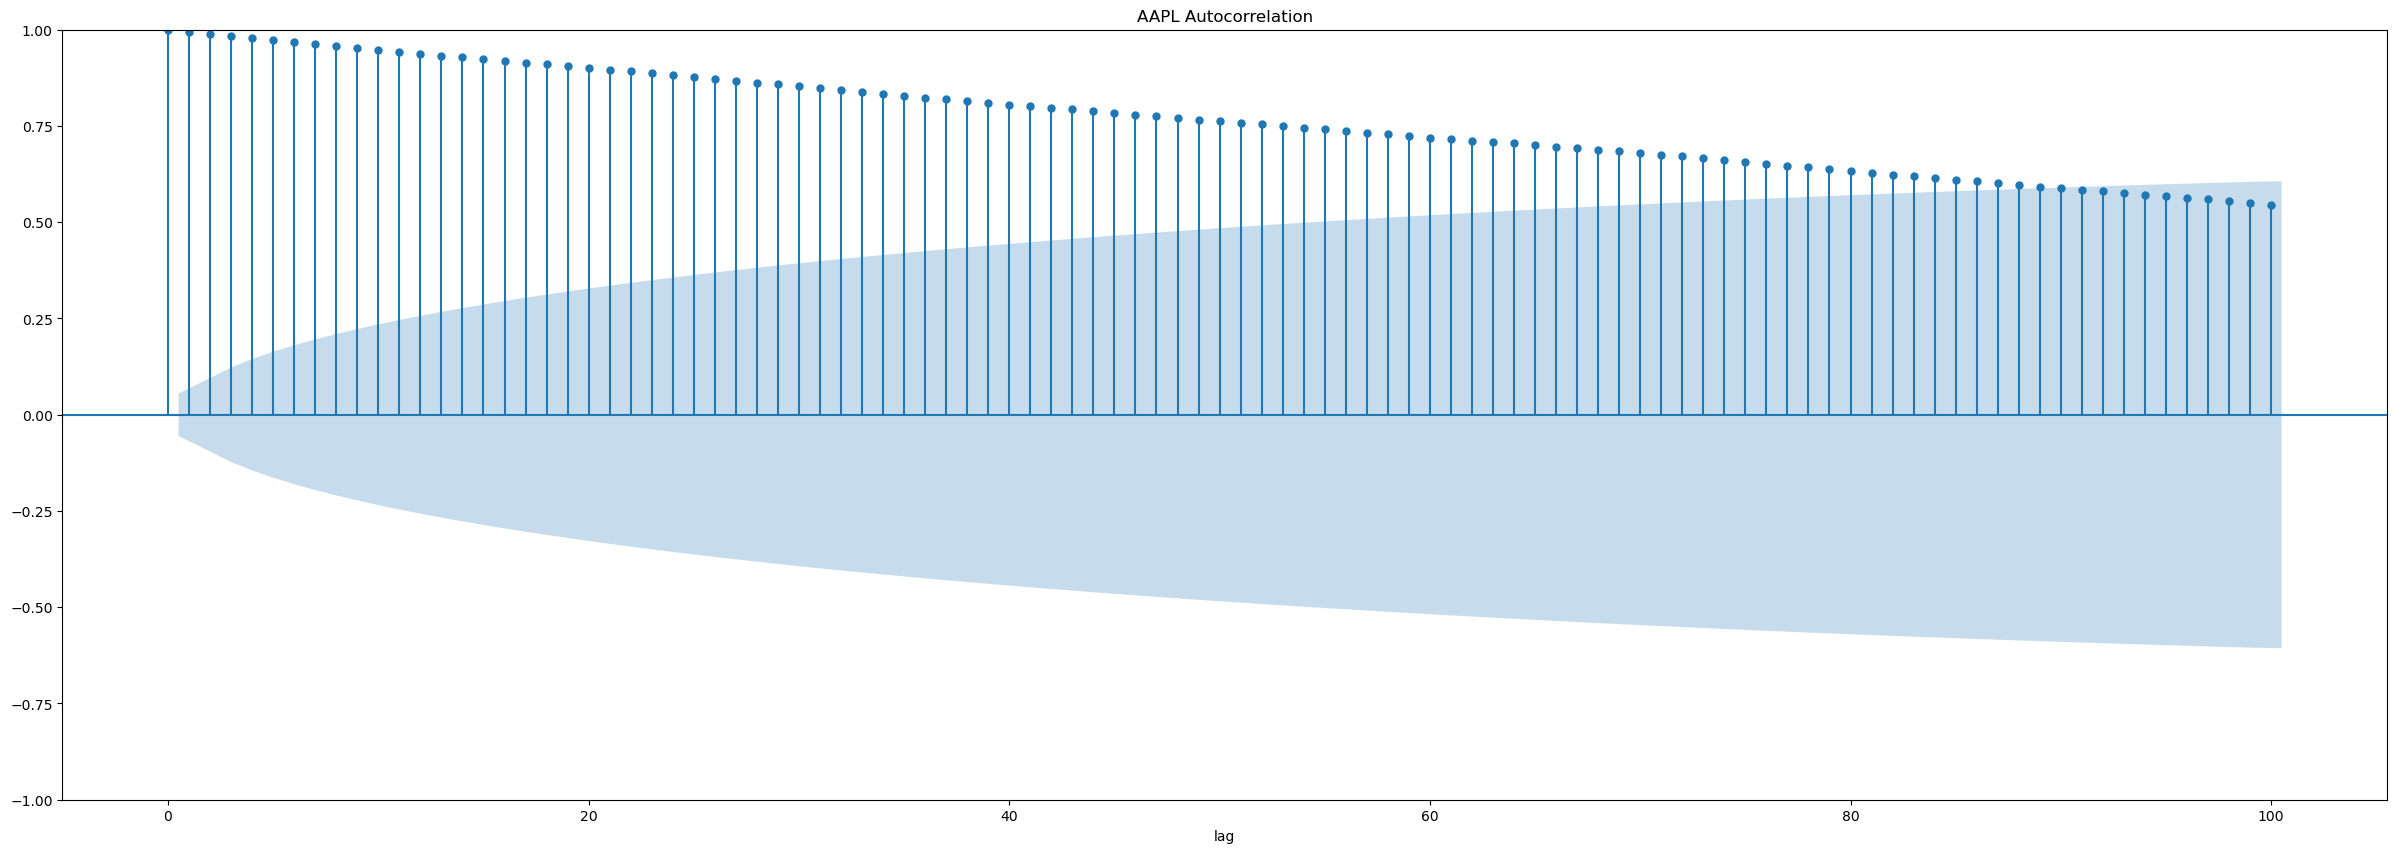

In [61]:
plt.figure(3,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_aapl_close, lags=100, title='AAPL Autocorrelation',alpha=0.05,ax=ax);

<Figure size 3000x1000 with 0 Axes>

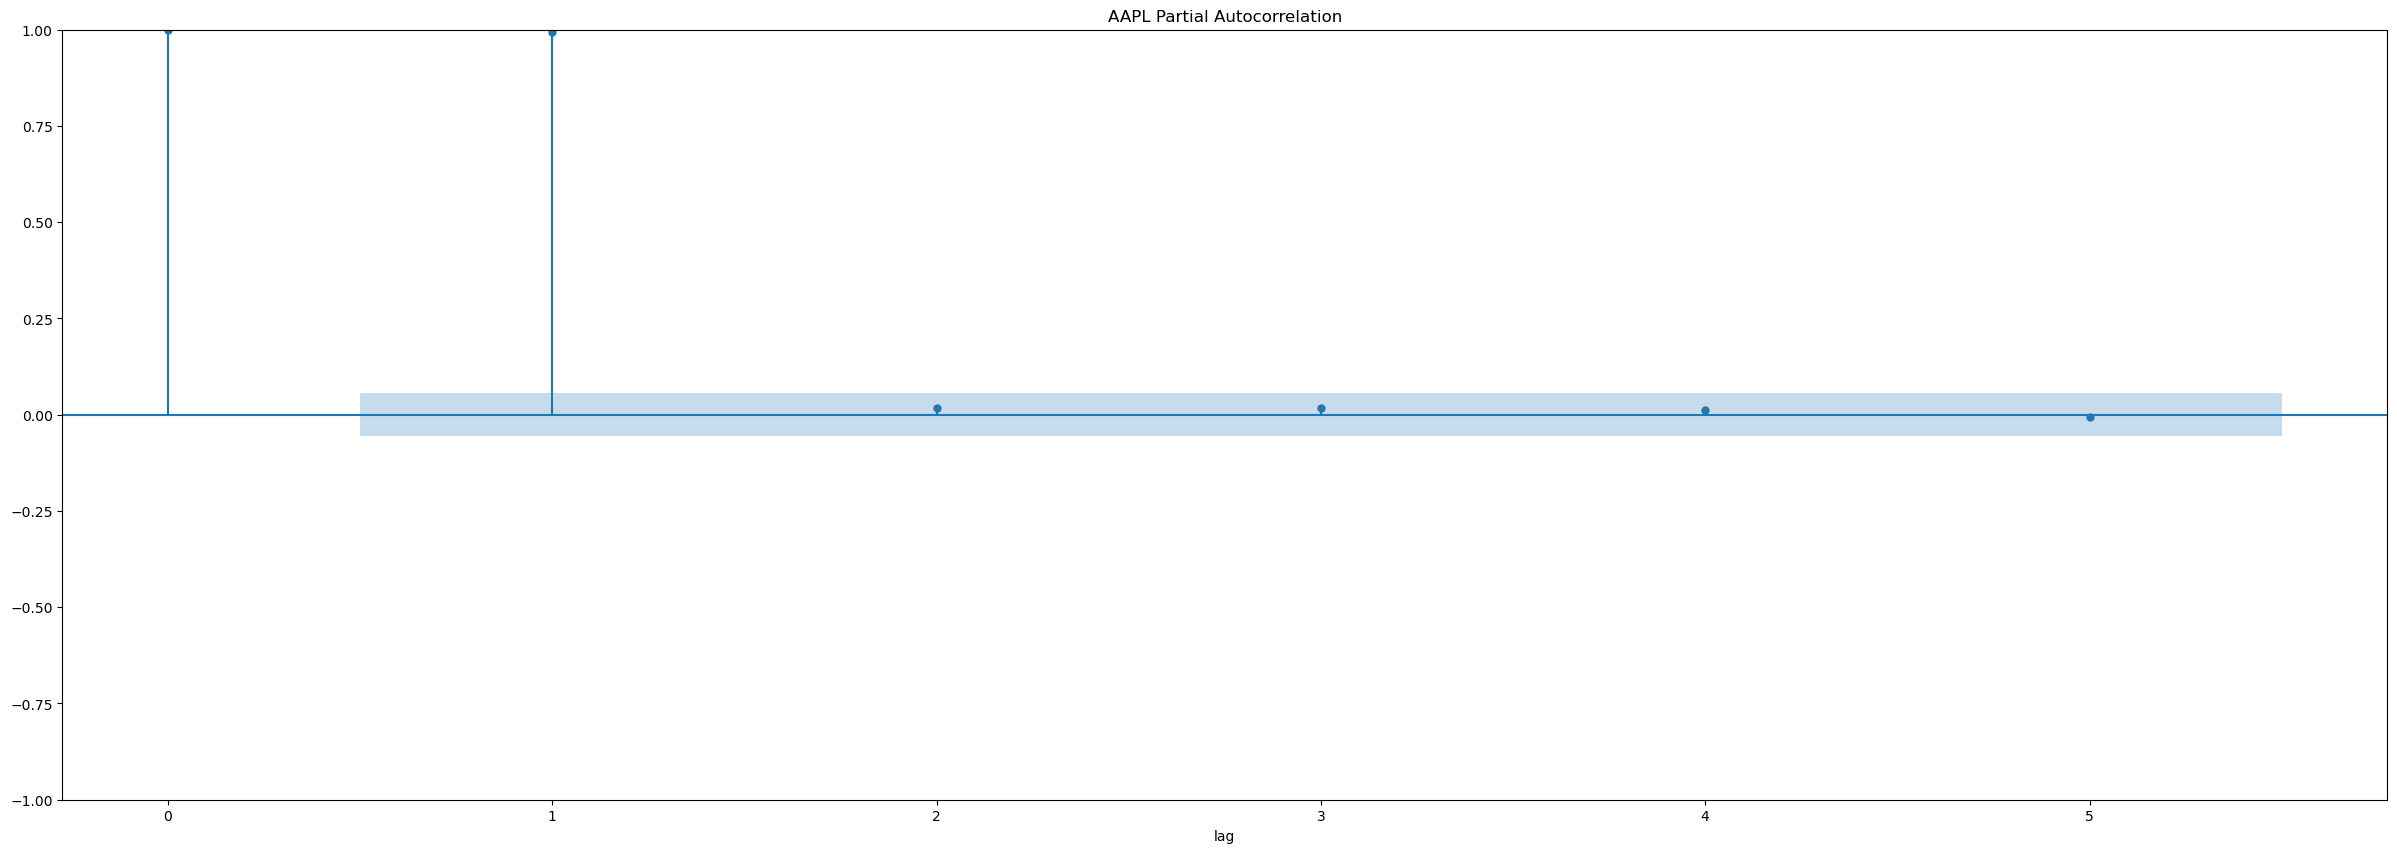

In [62]:
plt.figure(4,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_aapl_close, lags=5, title='AAPL Partial Autocorrelation',alpha=0.05,ax=ax);

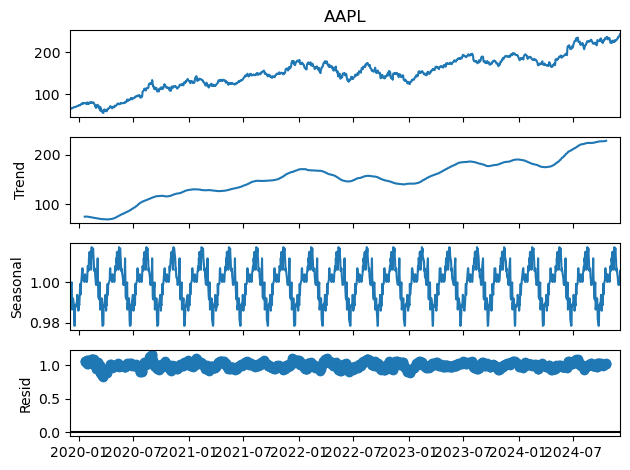

In [63]:
DAYS_PER_QUARTER= 63
result= seasonal_decompose(df_aapl_close,model='multiplicative',period=DAYS_PER_QUARTER)
o= result.plot()

In [65]:
####
# Run the augmented Dickey-Fuller Test
###
adfuller_test(df_aapl_close)

(-1.0391906040801568, 0.7387035101608905, 0, 1257, {'1%': -3.4355629707955395, '5%': -2.863842063387667, '10%': -2.567995644141416}, 5961.415174150818)
ADF Test Statistic : -1.0391906040801568
p-value : 0.7387035101608905
#Lags Used : 0
Number of Observations : 1257
weak evidence against null hypothesis,indicating it is non-stationary 


In [66]:
#######
#  Tools are in place in Python to experiment with ARIMA and
#  propose the parameters (p,d,q)
####

DO_IT= False

if (DO_IT):
    stepwise_fit = auto_arima(df_aapl_close, start_p = 1, start_q = 1, 
                              max_p = 3, max_q = 3, m = 12, 
                              start_P = 0, seasonal = True, 
                              d = None, D = 1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwis

    stepwise_fit.summary()

In [67]:
####### 
#  Fit the SARIMAX model
#
#  SARIMAX( nonseasonal, seasonal)
#
#  nonseasonaly= (p,d,q)
#
#  p: regression window size
#  d: differencing order
#  q: moving average (prediction error window)
#
#  seasonal=  (P,D,Q, m)
#
#  P: regression window size
#  D: differencing order
#  Q: moving average (prediction error window)
#
###

model = SARIMAX(df_aapl_close,  
                order = (2,1,1),  
                seasonal_order =(4, 1, 1, 20)) 
  
result = model.fit() 
result.summary() 

/Users/gholness/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gholness/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52648D+00    |proj g|=  1.04268D-01

At iterate    5    f=  2.45588D+00    |proj g|=  3.19785D-02

At iterate   10    f=  2.41084D+00    |proj g|=  5.15482D-02

At iterate   15    f=  2.39939D+00    |proj g|=  1.66169D-02

At iterate   20    f=  2.39799D+00    |proj g|=  2.69228D-03

At iterate   25    f=  2.39793D+00    |proj g|=  1.07413D-04

At iterate   30    f=  2.39792D+00    |proj g|=  6.48631D-05

At iterate   35    f=  2.39792D+00    |proj g|=  6.85592D-04

At iterate   40    f=  2.39792D+00    |proj g|=  6.15152D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               AAPL   No. Observations:                 1258
Model:             SARIMAX(2, 1, 1)x(4, 1, 1, 20)   Log Likelihood               -3016.583
Date:                            Thu, 05 Dec 2024   AIC                           6051.167
Time:                                    11:38:20   BIC                           6097.251
Sample:                                         0   HQIC                          6068.500
                                           - 1258                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4107      0.677      0.607      0.544      -0.916       1.738
ar.L2         -0.0222      0.034     -0.651      0.515      -0.089       0.045
ma.L1         -0.4293      0.678     -0.633      0.527      -1.759       0.900
ar.S.L20      -0.0204      0.030     -0.690      0.490      -0.078       0.038
ar.S.L40      -0.0439      0.029     -1.490      0.136      -0.102       0.014
ar.S.L60      -0.0279      0.032     -0.870      0.384      -0.091       0.035
ar.S.L80      -0.0185      0.032     -0.575      0.565      -0.082       0.045
ma.S.L20      -0.9871      0.041    -24.145      0.000      -1.067      -0.907
sigma2         7.2448      0.300     24.120      0.000       6.656       7.834
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               164.71
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.00
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
df_aapl_close.size

1258

In [69]:
#######
# New index from Date Time
#
# Utility routine to fix issue with yfinance DateTime index
###
def computeDateList(startDate, numDays):
    dateList = []
    for x in range (0, numDays):
        dt= startDate + datetime.timedelta(days= x)
    
        dateList.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
        
    return dateList

In [70]:
origStartDate= datetime.datetime(2019,12,4)

forecastStartDate= datetime.datetime(2024,12,5)

HIST_DAYS= df_aapl_close.size

NUM_DAYS= 252

aaplDateIndex= computeDateList(origStartDate,HIST_DAYS)

forecastDateIndex= computeDateList(forecastStartDate, NUM_DAYS)


/Users/gholness/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/gholness/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0.5, 1.0, 'SARIMA forecast horizon= 256 steps')

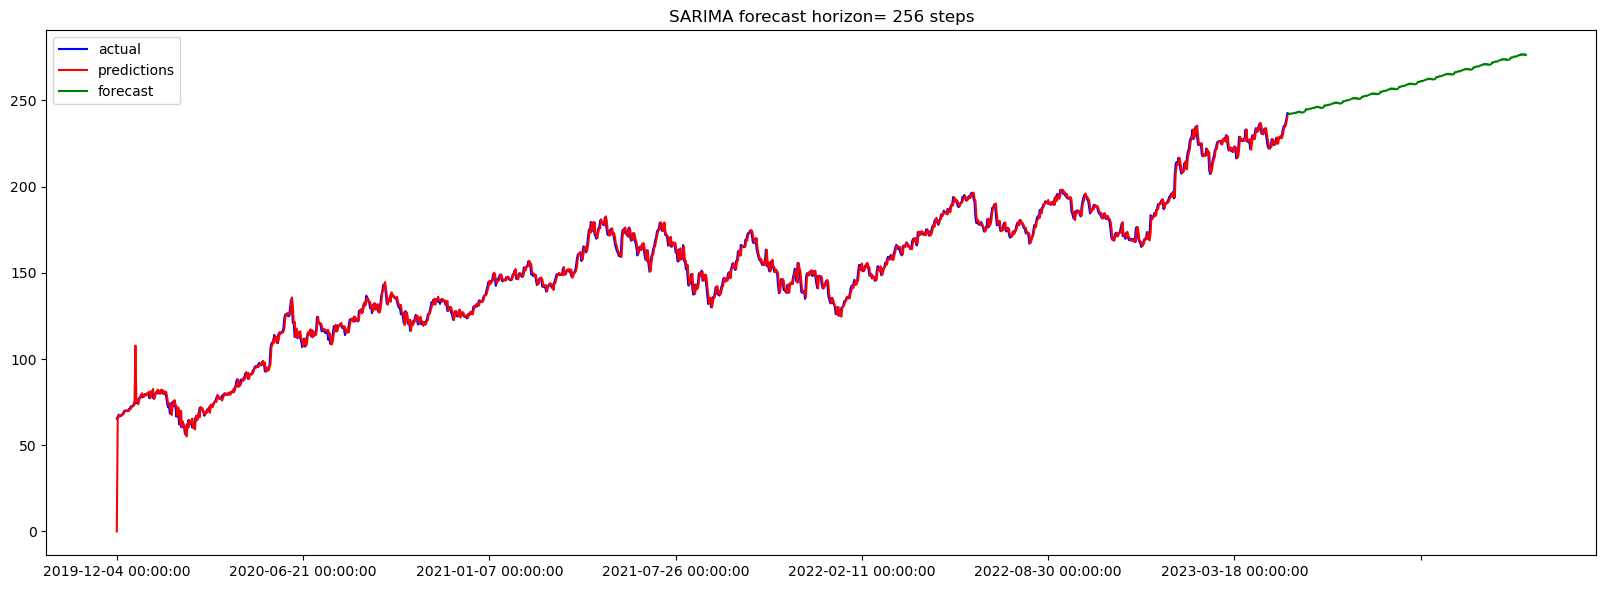

In [71]:
#######
# Use SARIMA model to do the forecast
# 
# Tinker with Series objects to properly set the index to good datetime format
####

ONE_QUARTER= 63 * 1
TWO_QUARTER= 63 * 2
THREE_QUARTER= 63 *3
FOUR_QUARTER= 64* 4

forecastHorizon= FOUR_QUARTER

####
# do the forecast over time horizon (future days)
##
forecast= result.forecast(steps=forecastHorizon)

#myForecast= pd.Series(forecast.values, index=forecastDateIndex)

####
# do prediction over existing time series
##
predictions= result.predict()

####
# set Series index to proper datetime formatted strings
##
myPredictions= pd.Series(predictions.values, index= aaplDateIndex)

myAAPLClose= pd.Series(df_aapl_close.values, index= aaplDateIndex)

####
# Visualize
###
plt.figure(12,figsize=(20,15))
plt.subplot(2,1,1)
myAAPLClose.plot(color='blue',label='actual')
myPredictions.plot(color='red',label='predictions')
forecast.plot(color='green',label='forecast')
plt.legend()
plt.title(f'SARIMA forecast horizon= {forecastHorizon} steps')

<Figure size 3000x1000 with 0 Axes>

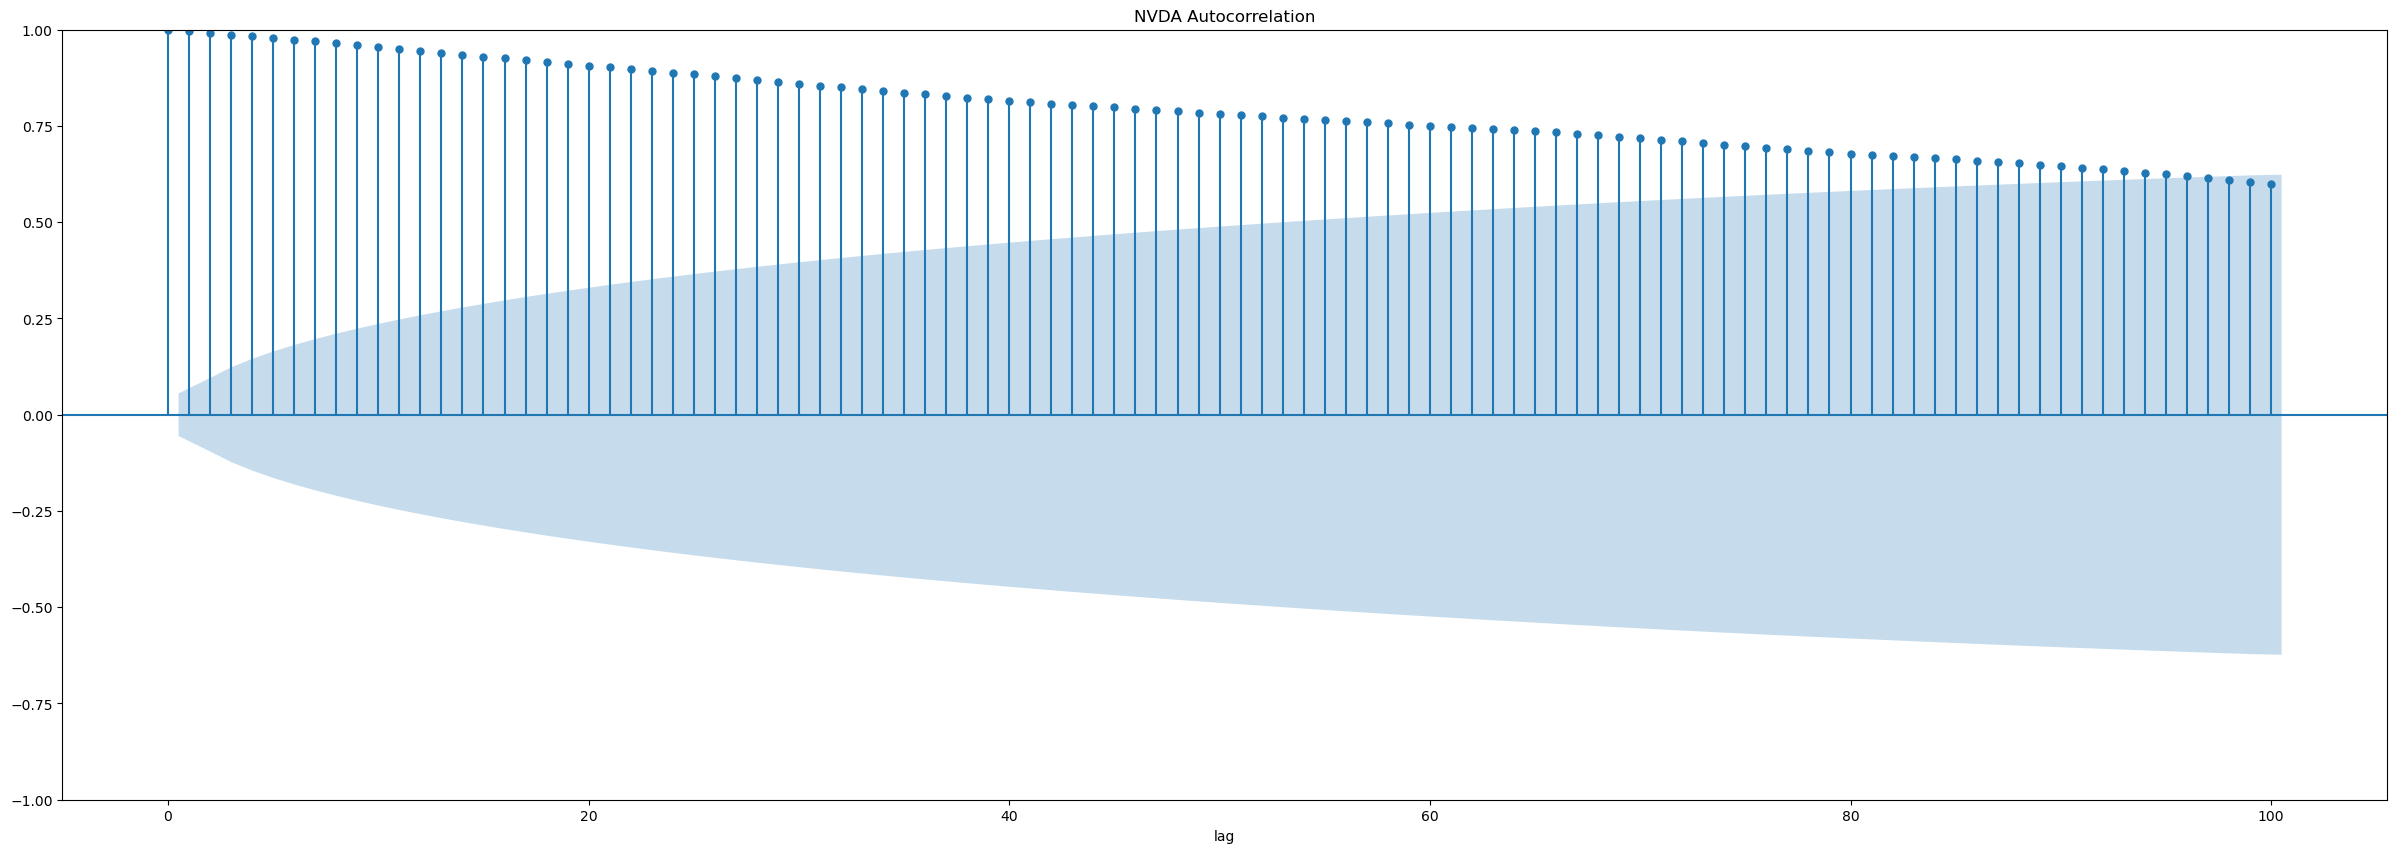

In [31]:
plt.figure(5,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_nvidia_close, lags=100, title='NVDA Autocorrelation',alpha=0.05,ax=ax);

<Figure size 3000x1000 with 0 Axes>

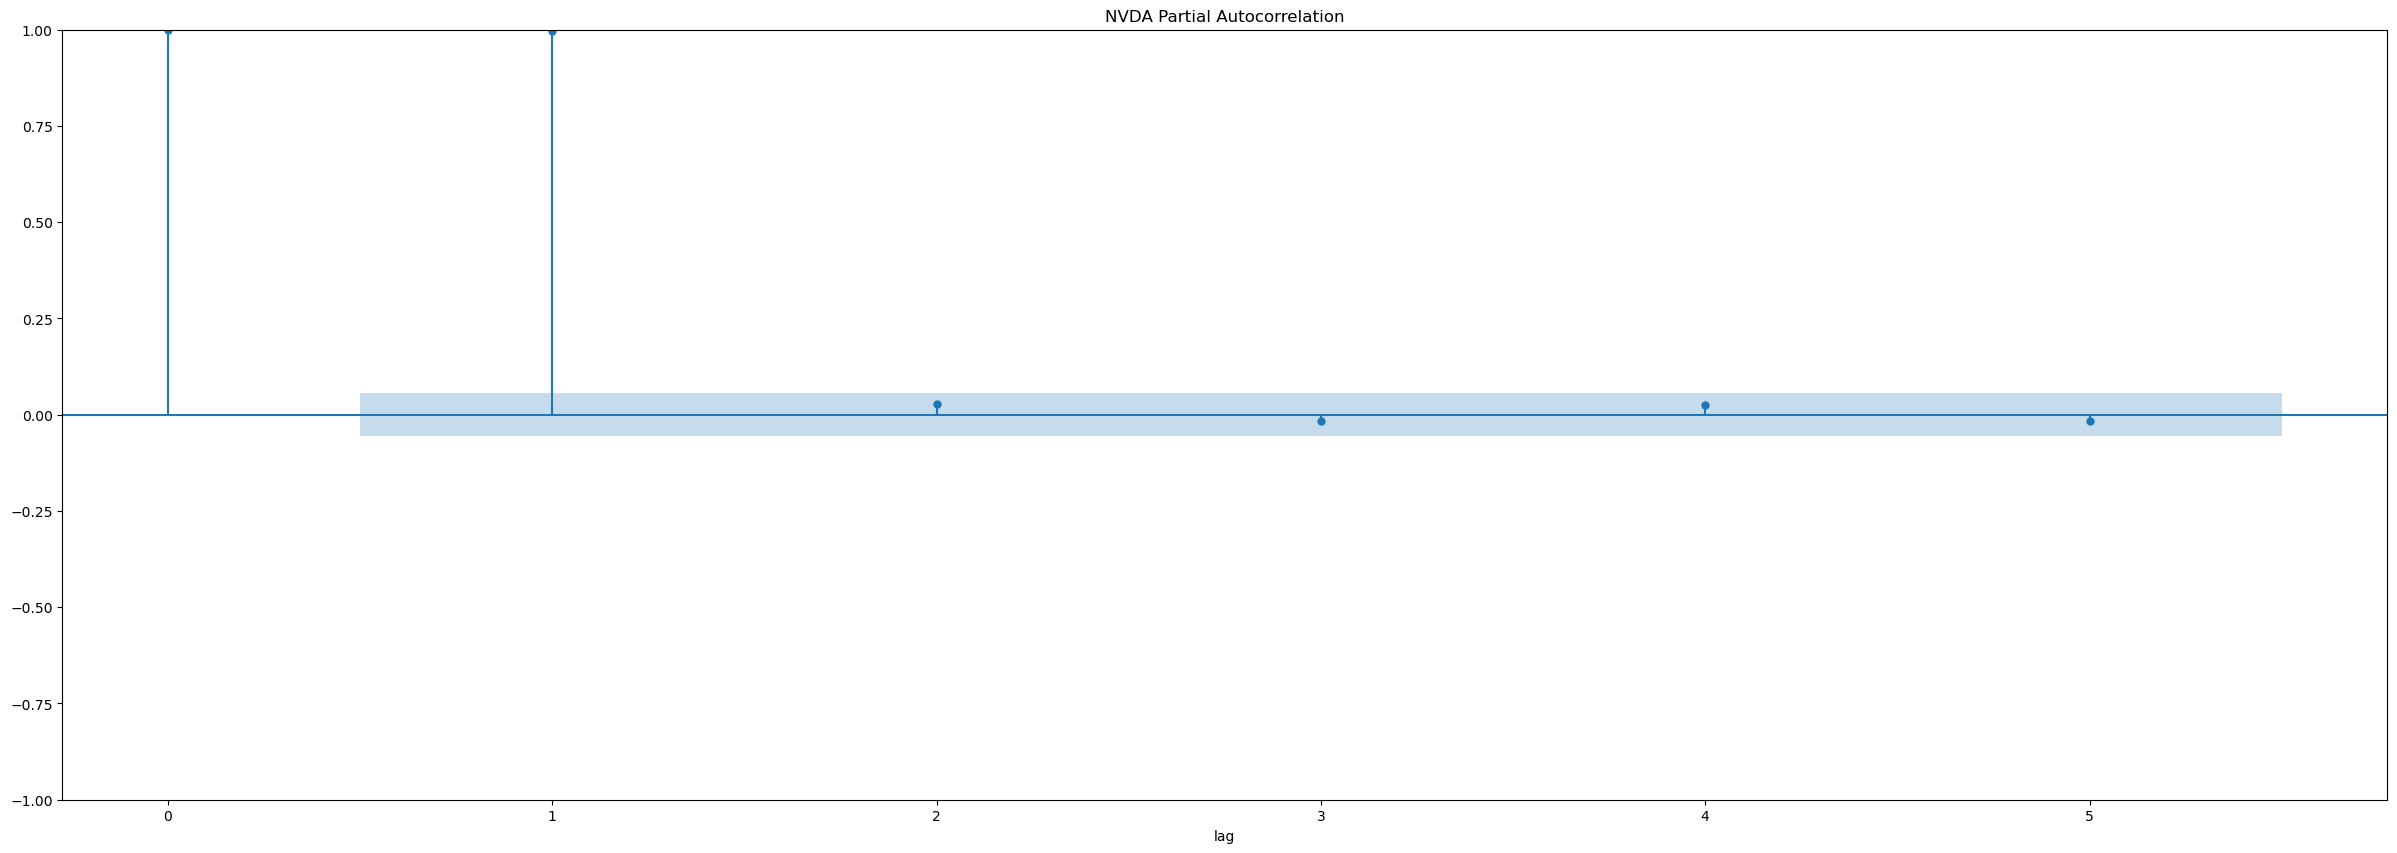

In [32]:
plt.figure(6,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_nvidia_close, lags=5, title='NVDA Partial Autocorrelation',alpha=0.05,ax=ax);

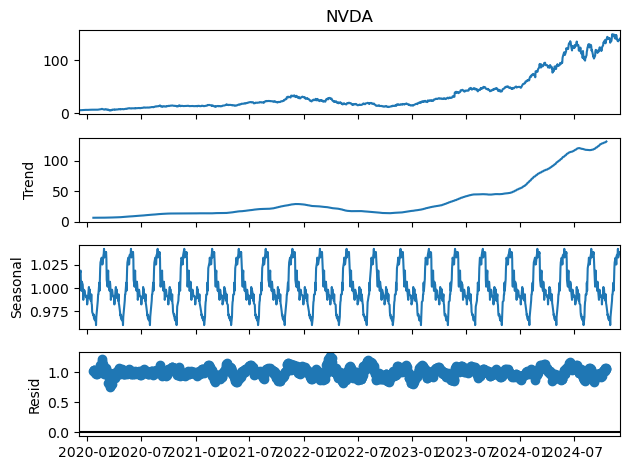

In [33]:
######
# Break time-series into it's constituent parts
#
# - level
# - trend
# - seasonality
# - noise
#
#  x(t) = Level + Trend + Seasonality + Noise
##
DAYS_PER_QUARTER= 63
result= seasonal_decompose(df_nvidia_close,model='multiplicative',period=DAYS_PER_QUARTER)
o= result.plot()

In [34]:
test_result=adfuller_test(df_nvidia_close)
test_result

(1.4684980365656646, 0.9974041471594299, 21, 1236, {'1%': -3.435651725648415, '5%': -2.863881223119536, '10%': -2.568016498910778}, 4704.341137041438)
ADF Test Statistic : 1.4684980365656646
p-value : 0.9974041471594299
#Lags Used : 21
Number of Observations : 1236
weak evidence against null hypothesis,indicating it is non-stationary 
